# **AI for Healthcare**

## **Overview**

In this notebook, a binary classifier model is developed to detect a specific health condition by analyzing medical data. The dataset consists of 800 patient data, including 70 medical indicators (features) and a target (label) variable. It is divided into 3 sets for different purposes. The classification model is trained solely on the training set (600 samples), has its hyperparameters validated with the validation set (100 samples), and is ultimately evaluated using the testing set (100 samples).



## **Setting up the environment**

Here various python libraries are used to develop the classification model.

In [1]:
#ignore warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
from collections import OrderedDict
import random
import os

# models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# preprocessing data for feature engineering

from sklearn.preprocessing import StandardScaler
from missforest import MissForest
from sklearn.metrics import roc_curve, auc, log_loss


# deep learning
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import Dataset, DataLoader

# optimization
import optuna
from optuna.samplers import TPESampler



# evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# shap value
import shap
shap.initjs()



## **Data Preparation**

In [2]:
# Load data
trainset = pd.read_csv('dataset/train_1.csv',index_col='ID')
validset = pd.read_csv('dataset/val_1.csv',index_col='ID')
test_X = pd.read_csv('dataset/test_1.csv',index_col='ID')
train_X, train_y = trainset.drop(columns=['Target']), trainset['Target'].to_numpy()
valid_X, valid_y = validset.drop(columns=['Target']), validset['Target'].to_numpy()

# Set the seed for reproducibility
seed = 33 
g = torch.Generator()
def fix_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)  # For GPU
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable the benchmark for reproducibility
    g.manual_seed(seed)
    
# column name
col_name = trainset.drop(columns=['Target']).columns


Text(0, 0.5, 'Null Value Count')

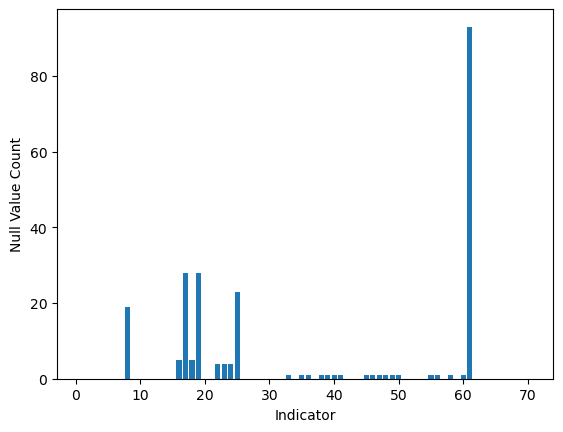

In [3]:
# null value count
plt.bar(range(1,71), trainset.iloc[:,:-1].isna().sum(axis=0),width = 0.8)
plt.xlabel('Indicator')
plt.ylabel('Null Value Count')

In [4]:
# data info
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 0 to 599
Data columns (total 70 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Indicator1   600 non-null    float64
 1   Indicator2   600 non-null    float64
 2   Indicator3   600 non-null    float64
 3   Indicator4   600 non-null    float64
 4   Indicator5   600 non-null    float64
 5   Indicator6   600 non-null    float64
 6   Indicator7   600 non-null    float64
 7   Indicator8   581 non-null    float64
 8   Indicator9   600 non-null    float64
 9   Indicator10  600 non-null    float64
 10  Indicator11  600 non-null    float64
 11  Indicator12  600 non-null    float64
 12  Indicator13  600 non-null    float64
 13  Indicator14  600 non-null    float64
 14  Indicator15  600 non-null    float64
 15  Indicator16  595 non-null    float64
 16  Indicator17  572 non-null    float64
 17  Indicator18  595 non-null    float64
 18  Indicator19  572 non-null    float64
 19  Indicator20  

In [5]:
# data describe
train_X.describe()

,Indicator1,Indicator2,Indicator3,Indicator4,Indicator5,Indicator6,Indicator7,Indicator8,Indicator9,Indicator10,...,Indicator61,Indicator62,Indicator63,Indicator64,Indicator65,Indicator66,Indicator67,Indicator68,Indicator69,Indicator70
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.0000,600.000000,581.000000,600.000000,600.000000,...,507.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.00000,600.000000,600.000000
mean,7.239417,4.675317,92.131500,327.770167,30.222167,12.8645,24.268813,43.102926,28.442411,1.972550,...,7984.500986,0.932550,13.708833,1.218583,17.566167,11.268500,25.698667,0.97890,3.553917,105.174333
std,3.006988,0.577290,7.237105,10.723553,2.767048,1.2392,6.089519,3.836181,8.003778,0.597032,...,1808.731729,0.202278,2.894414,0.468339,1.220282,0.760167,3.455991,0.06901,0.933665,14.895414
min,2.620000,2.520000,61.900000,280.000000,18.500000,10.9000,1.543000,31.400000,2.300000,0.750000,...,2299.000000,0.360000,4.000000,0.400000,14.400000,8.100000,17.600000,0.70000,1.380000,62.700000
25%,5.810000,4.337500,89.575000,322.000000,29.200000,12.1000,20.073000,40.500000,22.704844,1.500000,...,6858.000000,0.800000,11.900000,0.907500,16.700000,10.800000,23.400000,0.94000,2.920000,96.100000
50%,6.900000,4.665000,92.500000,328.000000,30.500000,12.6000,24.331000,42.800000,28.216887,1.930000,...,7933.000000,0.910000,13.800000,1.160000,17.600000,11.200000,25.300000,0.97000,3.425000,105.100000
75%,8.185000,4.970000,96.100000,334.000000,31.700000,13.2000,28.499250,45.100000,33.418669,2.300000,...,8970.500000,1.020000,15.700000,1.430000,18.300000,11.700000,27.400000,1.02000,4.072500,113.975000
max,62.500000,7.080000,112.000000,360.000000,37.500000,25.9000,42.116000,58.900000,63.333333,4.260000,...,18143.000000,2.840000,21.400000,5.920000,23.200000,14.500000,41.200000,1.27000,7.110000,190.500000


### **Imputation**

Each sample’s missing values are imputed using MissForest algorithm. To avoid unnecessary repetitive imputation, the processed data is stored in dicrectory "processed" after imputation. 

In [6]:
process_dir =  os.path.join('dataset','processed')
train_X_path = os.path.join(process_dir,'train_X.csv')
valid_X_path = os.path.join(process_dir,'valid_X.csv')
test_X_path = os.path.join(process_dir,'test_X.csv')

if  (not os.path.exists(train_X_path)) or (not os.path.exists(valid_X_path))  or (not os.path.exists(test_X_path)) :
    if not os.path.exists(process_dir):
        os.mkdir(process_dir)

    # impute data
    imputer = MissForest(max_iter=3,initial_guess='median')
    imputer.fit(train_X)
    train_X = imputer.transform(train_X)
    valid_X = imputer.transform(valid_X)
    test_X = imputer.transform(test_X)

    # save imputed data
    train_X.to_csv(train_X_path)
    valid_X.to_csv(valid_X_path)
    test_X.to_csv(test_X_path)
else:
    # load imputed data
    train_X = pd.read_csv(train_X_path,index_col='ID')
    valid_X = pd.read_csv(valid_X_path,index_col='ID')
    test_X = pd.read_csv(test_X_path,index_col='ID')


### **Standardization**

As the scales of features are so different, all features are standardized to have a mean of 0 and a standard deviation of 1 

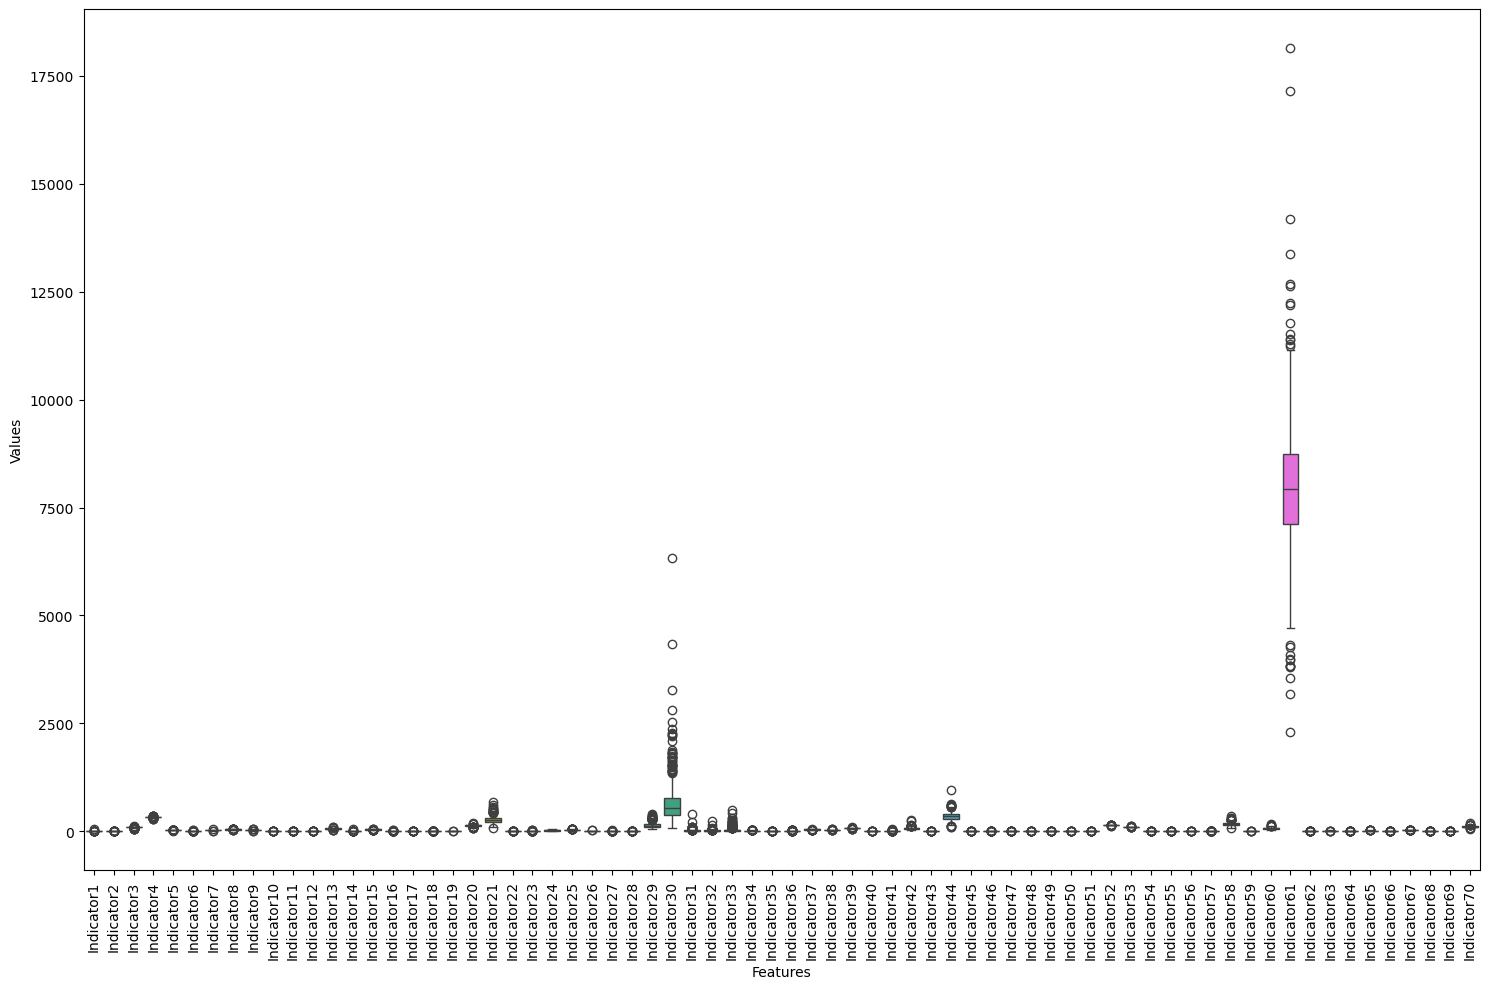

In [ ]:
def box_plot(data: pd.DataFrame):
    # Set the size of the plot
    plt.figure(figsize=(15, 10))

    # Create a box plot for all features
    sns.boxplot(data=data)


    # Adding titles and labels
    plt.xlabel('Features')
    plt.ylabel('Values')

    # Rotate x labels for better visibility
    plt.xticks(rotation=90)

    # Show the plot
    plt.tight_layout()  # Adjust layout
    plt.show()

# Data distribution before standardization
box_plot(train_X)

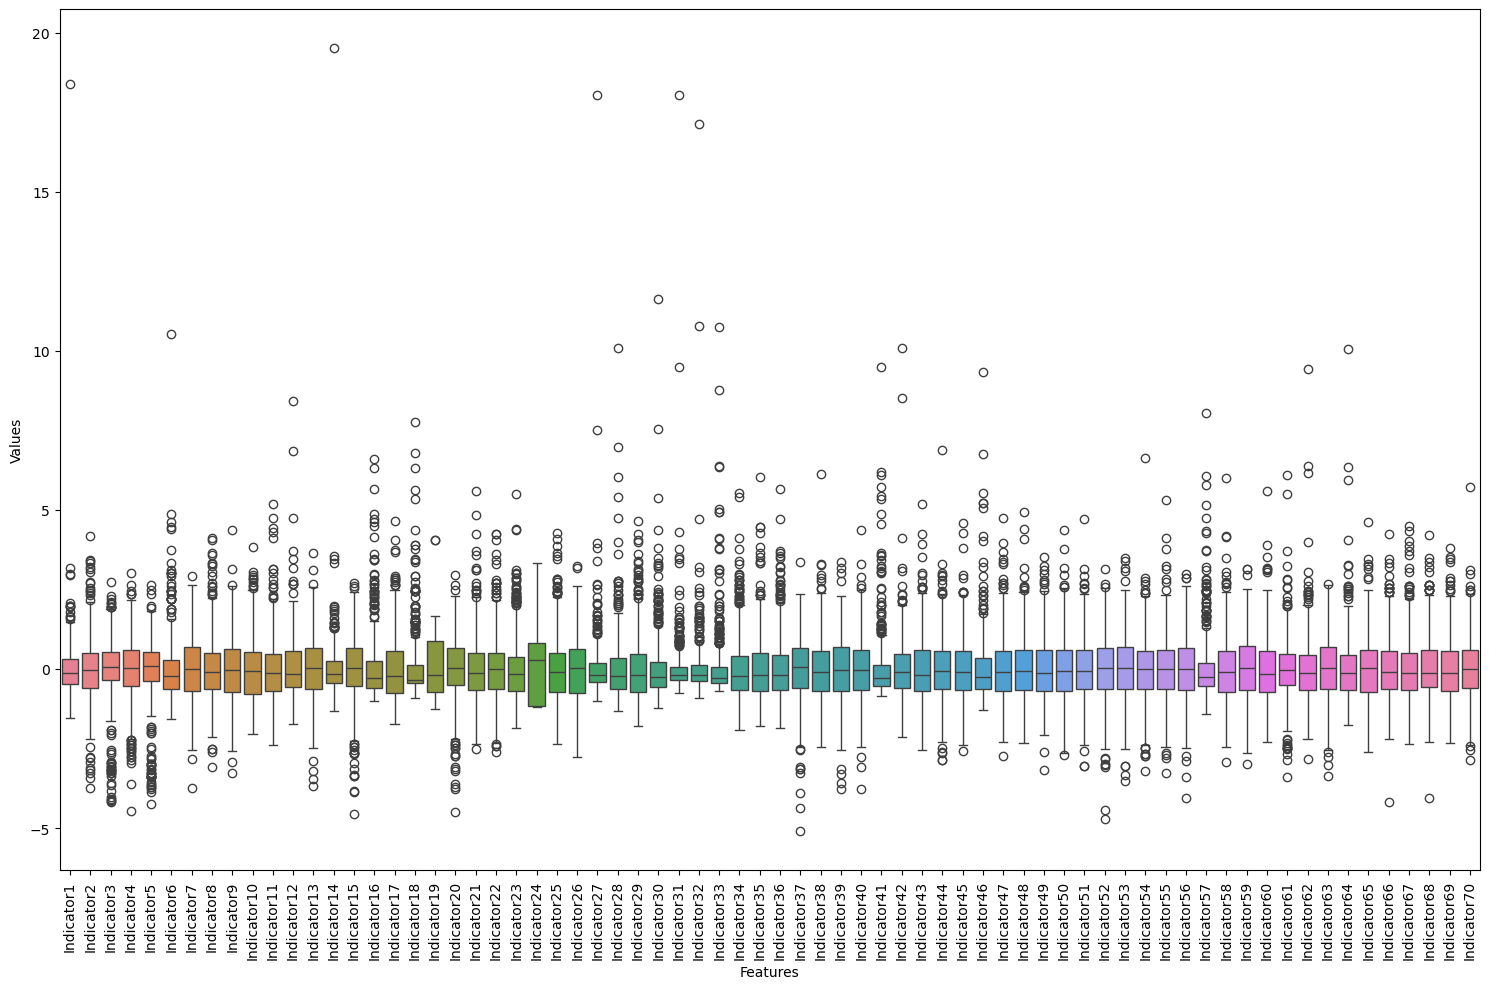

In [8]:
# Standardize all data set
scaler = StandardScaler()
scaler.fit(train_X)
train_X = scaler.transform(train_X)
valid_X = scaler.transform(valid_X)
test_X = scaler.transform(test_X)

# Data distribution after standardization
box_plot(pd.DataFrame(train_X,columns=trainset.columns[:-1]))

## **Model training and evaluation**

Evalute model performance based on binary cross-engotropy, accuracy, precision, recall, specificity, and AUC.

In [9]:
def evaluation(true_y, pred_y):
    """
    Evaluate prediction with true labels

    Args:
        true_y (list): True label
        pred_y (list): Prediction

    Return:
        Tuple: (entropy, acc, precision, recall, specificity, f1, auc)
    """
    if pred_y.shape[1] > 1:
        pred_y = pred_y[:,1:2]
    auc = roc_auc_score(true_y, pred_y)
    entropy = log_loss(true_y, pred_y)
    pred_y = (pred_y >= 0.5).astype(int)
    acc = accuracy_score(true_y, pred_y)
    precision = precision_score(true_y, pred_y)
    recall = recall_score(true_y, pred_y, pos_label=1)
    specificity = recall_score(true_y, pred_y, pos_label=0)
    f1 = f1_score(true_y, pred_y)

    return (entropy, acc, precision, recall, specificity, f1, auc)

### **Baseline**

In [10]:

models = [SVC(random_state=seed,probability=True), 
          LogisticRegression(random_state=seed), 
          DecisionTreeClassifier(random_state=seed), 
          RandomForestClassifier(random_state=seed), 
          AdaBoostClassifier(random_state=seed), 
          KNeighborsClassifier(), # KNeighborsClassifier has no attribute "random_state"
          GaussianNB(), # GaussianNB has no attribute "random_state"
          MLPClassifier(random_state=seed),
]

# record: save evaluation metrics for baselines and the optimized model
records = []

print('==========================================================')
for model in tqdm(models):
    modelname = type(model).__name__
    clf = model
    clf.fit(train_X,train_y)
    pred = clf.predict_proba(valid_X)
    # acc_train = accuracy_score(train_y, pred)
    eval_metric = evaluation(valid_y,pred)
    records.append((modelname,*eval_metric))

100%|██████████| 8/8 [00:01<00:00,  7.50it/s]


### **Neural Network Optimization**

Optuna is used to optimize neural network within 500 trails.

In [11]:
# Dataset

class HealthData(Dataset):
    def __init__(self, data_X, data_y=None) -> None:
        super().__init__()
        self.data_X = data_X
        self.data_y = data_y

    def __getitem__(self, index):
        if self.data_y is None:
            return self.data_X[index]
        else:
            return self.data_X[index], self.data_y[index]
    
    def __len__(self):
        return len(self.data_X)

In [12]:
# Neural Network Hyperparameter Tuning Using Optuna
# test : 0.6

def plot_loss(train_loss, valid_loss):
    """
    Plot the training and validation loss across epochs.

    Args:
        train_loss (list): List of training losses across epochs.
        valid_loss (list): List of validation losses across epochs.
    """
    epochs = range(1, len(train_loss) + 1)

    # Set the figure size
    plt.figure(figsize=(10, 4))  # width, height
    
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, valid_loss, label='Validation Loss')
    
    # Find the best epoch (lowest validation loss)
    best_epoch = epochs[valid_loss.index(min(valid_loss))]
    print(best_epoch)

    # Highlight the best epoch
    # plt.scatter(best_epoch, best_loss, color='red', label='Best Epoch')
    plt.axvline(best_epoch, color='red', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(handles=[plt.Line2D([0], [0], color='blue', label='Training Loss'),
                    plt.Line2D([0], [0], color='orange', label='Validation Loss'),
                    plt.Line2D([0], [0], color='red', linestyle='--', label='Best Epoch')])
    plt.show()

def define_model(trial):
    """
    Contruct model structure by Optuna

    Args:
        trial (Optuna.Trail): a process of evaluating an objective function.

    Return:
        PyTorch model
    """
    # We optimize the number of layers, type of activation, hidden units and dropout ratio in each layer except output layer.
    n_layers = trial.suggest_int("n_layers", 2, 5)
    # activation_name = trial.suggest_categorical("activation", ["PReLU", "ReLU", "ELU", "Tanh","GELU"])
    layers = []
    in_features = 70
    for i in range(n_layers - 1):
        out_features = trial.suggest_int("n_units_l{}".format(i), 16, 140)
        layers.append(nn.Linear(in_features, out_features))
        activation_name = trial.suggest_categorical("activation_l{}".format(i), ["PReLU", "ReLU", "ELU", "Tanh", "GELU"])
        layers.append(getattr(nn,activation_name)())
        p = trial.suggest_float("dropout_l{}".format(i), 0.1, 0.5)
        layers.append(nn.Dropout(p))
        in_features = out_features
    layers.append(nn.Linear(out_features, 1))

    return nn.Sequential(*layers)

def train_model(trial, train_loader, valid_loader, show_plot=False):
    """
    Train model with hyperparameters defined by Optuna

    Args:
        trial (Optuna.Trail): a process of evaluating an objective function.
        train_loader (Dataloader): PyTorch Dataloader for training set.
        valid_loader (Dataloader): PyTorch Dataloader for validation set.
        show_plot (boolean) optional: Plot train loss and valid loss across epochs

    Return:
        best_score: lowest validation loss
        model: PyTorch Model with best score
    """
    device='cuda'
    epochs = 100
    loss_f = nn.BCEWithLogitsLoss()
    best_score = 1e4
    
    # Generate the model.
    model = define_model(trial)

    # set early stopping
    early_stop_patience = 20

    # Generate the optimizer
    optimizer_name = trial.suggest_categorical("optimizer", ["RMSprop", "SGD", "Adam"])
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    momentum = trial.suggest_float('momentum', 0.4, 0.99)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True)

    if optimizer_name == "Adam":
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(momentum,0.99))
    else:
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)


    #Generate the scheduler 
    scheduler_patience = trial.suggest_int("scheduler_patience", 1, 20)
    scheduler_factor = trial.suggest_float("scheduler_factor", 1e-3, 1e-1, log=True)
    scheduler = ReduceLROnPlateau(optimizer,mode='min',factor=scheduler_factor, patience=scheduler_patience)

    model = model.to(device)
    # track loss of training set and validation set across epochs
    all_train_loss = []
    all_valid_loss = []
    # Training of the model.
    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device,dtype=torch.float), target.view(-1,1).to(device,dtype=torch.float)
            optimizer.zero_grad()
            
            output = model(data)
            loss = loss_f(output, target)

            loss.backward()

            # gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1e5)
            optimizer.step()

            with torch.no_grad():
                pred = F.sigmoid(output).cpu()

                if batch_idx == 0:
                    target_all = target.cpu()
                    pred_all = pred
                else:
                    target_all = torch.concat([target_all,target.cpu()],axis=0)
                    pred_all = torch.concat([pred_all,pred],axis=0)

        train_loss = log_loss(target_all,pred_all)
        all_train_loss.append(train_loss)

        model.eval()
        # Validation of the model.
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                data, target = data.to(device,dtype=torch.float), target.view(-1,1).to(dtype=torch.float)
                
                output = model(data)
                pred = F.sigmoid(output).cpu()

                if batch_idx == 0:
                    target_all = target
                    pred_all = pred
                else:
                    target_all = torch.concat([target_all,target],axis=0)
                    pred_all = torch.concat([pred_all,pred],axis=0)
            valid_loss = log_loss(target_all,pred_all)

        all_valid_loss.append(valid_loss)
        
        eval_score = valid_loss

        scheduler.step(eval_score)

        # eval_score = valid_acc
        if eval_score < best_score:
            best_score = eval_score
            patience = early_stop_patience  # Reset patience counter
            best_model_state_dict = OrderedDict({k:v.to('cpu') for k, v in model.state_dict().items()}) # save best model parameters
        else:
            patience -= 1
            if patience == 0:
                if show_plot:
                    plot_loss(all_train_loss,all_valid_loss)
                break

    model.load_state_dict(best_model_state_dict)  # load best model parameters
        
    return best_score, model

def objective(trial, return_model=False, show_plot=False):
    """
    Prepare dataloader and run train_model function to output validation loss for a trail of hyperparamter setting

    Args:
        trial (Optuna.Trail): a process of evaluating an objective function.
        return_model (boolean): Return model instead of best_score
        show_plot (boolean) optional: Plot train loss and valid loss across epochs

    Return:
        best_score: lowest validation loss
        model: PyTorch Model with best score
    """
    # fix seed to ensure reproducibility
    fix_seed(seed)
    
    batch_size = trial.suggest_int("batch_size", 4, 32)

    # Generate the dataloader
    dataloader_seed = seed


    train_loader = DataLoader(HealthData(train_X,train_y),
                            batch_size=batch_size,
                            shuffle=True, 
                            worker_init_fn=lambda worker_id: torch.manual_seed(dataloader_seed + worker_id),
                            generator=g,
                            pin_memory=True)
    valid_loader = DataLoader(HealthData(valid_X,valid_y),
                            batch_size=batch_size,
                            pin_memory=True)
    best_score, model = train_model(trial, train_loader, valid_loader, show_plot)

    if return_model:
        return model
    else:
        return best_score
    


In [ ]:
n_trails = 500
study = optuna.create_study(direction="minimize",study_name="Neural Network Classifier", sampler=TPESampler(seed=seed))
study.optimize(objective, n_trials=n_trails)

# save best study
with open(os.path.join('study',f'study_nn_TPE.pkl'), 'wb') as f:
    pickle.dump(study, f)

# save best model
model = objective(study.best_trial,return_model=True)
model.to('cpu')
torch.save(model.state_dict(), os.path.join('checkpoint',f'best_model_nn_TPE.pt'))

### **Evaluation**

45


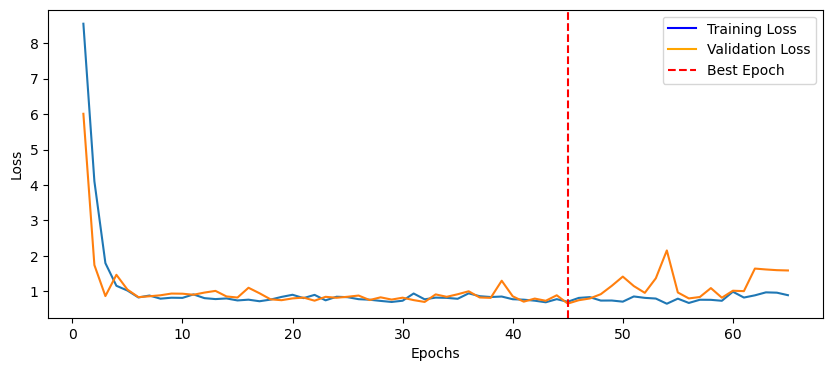

In [13]:
# plot train loss and valid loss for the best model

with open(os.path.join('study',f'study_nn_TPE.pkl'), 'rb') as f:
    study = pickle.load(f)

model = objective(study.best_trial,return_model=True,show_plot=True)


In [14]:

def infer_model(model,device='cpu'):
    """
    Take in PyTorch model into inference function
    Args:
        model (Pytorch.module): Pytorch model used for inference
        device (str): Device used for inference. Can be 'cpu' or 'cuda'.

    Return:
        infer: inference function that take numpy features as input to predict corresponding label. 
    """
    def infer(X):
        # Validation of the model.
        valid_loader = DataLoader(HealthData(X),
                                batch_size=100)
        model.eval()
        model.to(device)
        with torch.no_grad():
            for batch_idx, (data) in enumerate(valid_loader):
                data = data.to(device,dtype=torch.float)
                pred = model(data)

                if batch_idx == 0:
                    pred_all = pred
                else:
                    pred_all = torch.concat([pred_all,pred],axis=0)
            
            pred_all = F.sigmoid(pred_all).cpu()
            
            return pred_all.view(-1).numpy()
        
    return infer

In [15]:
# Load the study using pickle
with open(os.path.join('study',f'study_nn_TPE.pkl'), 'rb') as f:
    study = pickle.load(f)

# load best model
model = define_model(study.best_trial)
model.load_state_dict(torch.load(os.path.join('checkpoint','best_model_nn_TPE.pt')))

# output inference for testing set
preds = infer_model(model)(test_X)
preds = (preds >= 0.5).astype(int)

# save inference to be uploaded to Kaggle
pd.DataFrame(preds).reset_index().rename(
    columns={
        'index': 'ID',
        0: 'TARGET'
    }
).to_csv('test_prediction_nn.csv',index=False)



In [16]:
# append the optimized model's evaluation result on validation set
records.append((
    'Optimized Neural Network Model',
    *evaluation(valid_y,infer_model(model)(valid_X).reshape(-1,1))
))

# Output evaluation records of baselines and the neural network model
pd.DataFrame(records,columns=['Model Name','Binary Cross-Entropy','Accuracy', 'Precision', 'Recall', 'Specificity', 'F1', 'ROC-AUC']).to_csv('records_1.csv',index=False)

## **Explainable AI - SHAP**

shap's KernelExplainer, a model agnostic expalainer, is used to explain output of the optimized model

In [17]:
# construct SHAP explainer using training data as background information to explain output of validation set
explainer = shap.KernelExplainer(infer_model(model), pd.DataFrame(train_X,columns=trainset.columns[:-1]))
shap_values = explainer.shap_values(pd.DataFrame(valid_X,columns=trainset.columns[:-1]))


Using 600 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 100/100 [17:20<00:00, 10.40s/it]


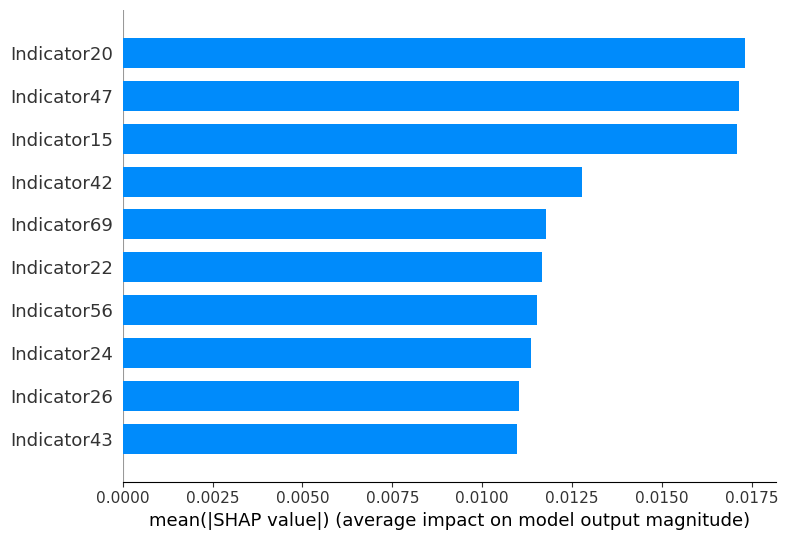

In [20]:
# Mean absolute SHAP value of top 10 features
shap.summary_plot(shap_values, pd.DataFrame(valid_X,columns=trainset.columns[:-1]), plot_type="bar",max_display=10)


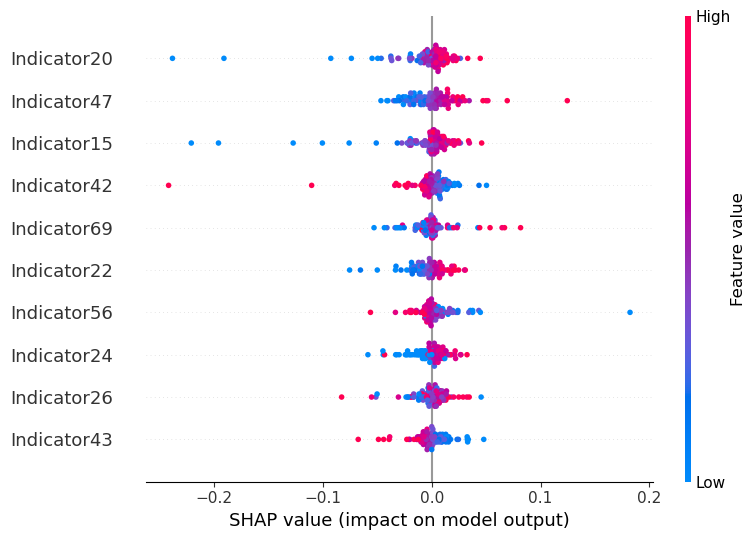

In [21]:
# SHAP value distribution of top 10 features
shap.summary_plot(shap_values, pd.DataFrame(valid_X,columns=trainset.columns[:-1]),max_display=10, plot_type="dot")